## 1. Install and import libraries

In [ ]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings('ignore', message="Coordinate descent without L1 regularization may lead to unexpected results and is discouraged.")
warnings.filterwarnings('ignore', category=ConvergenceWarning)

In [ ]:
# Basic
import numpy as np
import pandas as pd
import requests
import json

# Plotting
import matplotlib.pyplot as plt

# Scikit-Learn
from sklearn.metrics import mean_absolute_error, mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import sklearn.model_selection as skm
import sklearn.linear_model as skl

# Keras
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, Embedding
from keras.optimizers import RMSprop
from keras.preprocessing import sequence

# TensorFlow
from tensorflow.keras.datasets import mnist, cifar100, imdb
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.applications.resnet50 import ResNet50, decode_predictions
from tensorflow.keras.preprocessing.sequence import pad_sequences

## 2. Fit Linear Methods and Single Layer Neural Network

Let's use the ``hitters`` dataset to fit some models. First we perform the data cleaning stage.

In [ ]:
hitters = pd.read_csv('https://raw.githubusercontent.com/qlabpucp/datasets/main/datasets/hitters.csv')
hitters = hitters.dropna()
hitters = hitters.drop(columns = ['Unnamed: 0'])
hitters = pd.get_dummies(hitters, dtype='int')
hitters = hitters.drop(columns = ['League_A', 'Division_E', 'NewLeague_A'])
hitters = hitters.reindex()
hitters.shape

(263, 20)

We can split dataset using the ``train_test_split`` method from Scikit-Learn library

In [ ]:
target = [ 'Salary' ]
predictors = [ var for var in hitters.columns if var not in target ]

X_train, X_test, y_train, y_test = skm.train_test_split(hitters[predictors], hitters[target], test_size=0.33, random_state=0)

Now let's fit the following Linear Models:

- **Linear Regression:** A basic linear regression model is created, trained, and predictions are made on the test set. The MSE is computed for the predictions.

- **Ridge Regression:** A Ridge model is set up using ElasticNetCV with ``l1_ratio`` set to 0, indicating it's purely Ridge. The model undergoes K-Fold cross-validation to tune the lambda (regularization strength) parameter. Predictions are made on the test set and the MSE is calculated.

- **Lasso Regression:** Similar to Ridge, a Lasso model is implemented using ElasticNetCV, but with ``l1_ratio`` set to 1, indicating it's purely Lasso. The model is also subjected to K-Fold cross-validation for lambda tuning. Finally, predictions are made and the MSE is computed.

In [ ]:
# Linear Regression

lr_model = skl.LinearRegression()
lr_model.fit( X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
mse_lr = round( mean_squared_error(y_test, y_pred_lr), 3 )

# Ridge

cv = skm.KFold(n_splits=5, shuffle=True, random_state=2)
lambdas = 10**np.linspace(8, -2, 100)
ridgeCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=0, cv=cv)
scaler = StandardScaler()
pipeCV_ridge = Pipeline(steps=[('scaler', scaler), ('ridge', ridgeCV)])
pipeCV_ridge.fit(X_train, y_train)
y_pred_ridge = pipeCV_ridge.predict(X_test)
mse_ridge = round( mean_squared_error(y_test, y_pred_ridge), 3 )

# Lasso

LassoCV = skl.ElasticNetCV(alphas=lambdas, l1_ratio=1, cv=cv)
pipeCV_lasso = Pipeline(steps=[('scaler', scaler), ('lasso', LassoCV)])
pipeCV_lasso.fit(X_train, y_train)
y_pred_lasso = pipeCV_lasso.predict(X_test)
mse_lasso = round( mean_squared_error(y_test, y_pred_lasso), 3 )

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_coordinate_descent.py:1568: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Now let's fit a Single Layer Neural Network

- **Input and Hidden Layer:** The model starts with a densely connected layer (Dense) with 50 neurons, utilizing ReLU (Rectified Linear Unit) as the activation function. This layer is designed to receive input with a shape corresponding to the number of predictors in the dataset.

- **Dropout Layer:** A dropout layer is included to prevent overfitting. It randomly sets a portion of the input units (40% in this case) to 0 during training, which helps in making the model more robust and prevents over-reliance on specific input features.

- **Output Layer:** The output layer consists of a single neuron, as this is a regression model expected to predict a continuous value.

- **Compilation:** The model is compiled with the Mean Squared Error (mean_squared_error) loss function, suitable for regression tasks. The RMSprop optimization algorithm is used for training the model.
Training:

- **Training:** The model is trained for 1500 epochs with a batch size of 32. Validation data is also provided to monitor the model's performance on a separate test set during training.

In [ ]:
modnn = Sequential()
modnn.add(Dense(units=50, activation='relu', input_shape=(len(predictors),)))
modnn.add(Dropout(rate=0.4))
modnn.add(Dense(units=1))

modnn.compile(loss='mean_squared_error',
              optimizer=RMSprop(),
              metrics=['mean_squared_error'])

history = modnn.fit(X_train, y_train,
                    epochs=1500, batch_size=32,
                    validation_data=(X_test, y_test))

Epoch 1/1500
6/6 [==============================] - 2s 78ms/step - loss: 315778.3438 - mean_squared_error: 315778.3438 - val_loss: 198876.9375 - val_mean_squared_error: 198876.9375
Epoch 2/1500
6/6 [==============================] - 0s 21ms/step - loss: 235052.5156 - mean_squared_error: 235052.5156 - val_loss: 182105.2344 - val_mean_squared_error: 182105.2344
Epoch 3/1500
6/6 [==============================] - 0s 25ms/step - loss: 261979.3594 - mean_squared_error: 261979.3594 - val_loss: 179611.8594 - val_mean_squared_error: 179611.8594
Epoch 4/1500
6/6 [==============================] - 0s 29ms/step - loss: 291793.1250 - mean_squared_error: 291793.1250 - val_loss: 178250.4688 - val_mean_squared_error: 178250.4688
Epoch 5/1500
6/6 [==============================] - 0s 48ms/step - loss: 243291.3594 - mean_squared_error: 243291.3594 - val_loss: 172327.0000 - val_mean_squared_error: 172327.0156
Epoch 6/1500
6/6 [==============================] - 0s 55ms/step - loss: 242233.9531 - mean_squ

We compute the test error for the Single Layer Neural Network

In [ ]:
y_pred_nn = modnn.predict(X_test)
mse_nn = round( mean_squared_error(y_test, y_pred_nn), 3 )
mse_nn

3/3 [==============================] - 0s 3ms/step


109375.016

We can compare the performance of the different models here

In [ ]:
mse_values = {
    'Linear Regression': mse_lr, 'Ridge': mse_ridge, 'Lasso': mse_lasso, 'Neural Network': mse_nn
}
mse_df = pd.DataFrame(list(mse_values.items()), columns=['Model', 'MSE'])
mse_df

,Model,MSE
0,Linear Regression,140499.911
1,Ridge,124414.280
2,Lasso,131185.721
3,Neural Network,109375.016


We can visualize the Mean Squared Error for the Single Layer Neural Network over different epochs

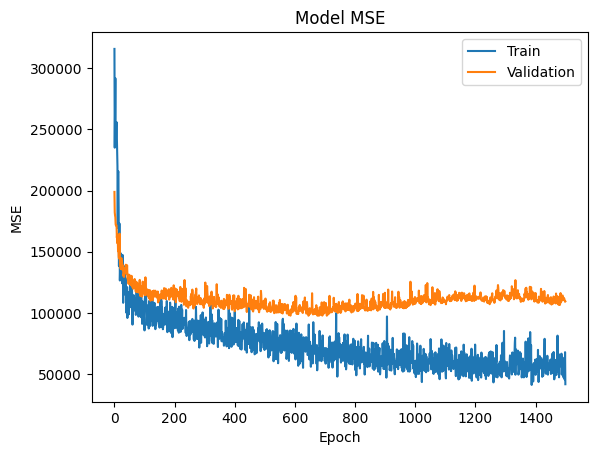

In [ ]:
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('Model MSE')
plt.ylabel('MSE')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()

## 3. Multilayer Neural Network

Now let's implement a Multilayer Neural Network using the MINST dataset

In [ ]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
print(x_train.shape)
print(x_test.shape)

11490434/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(10000, 28, 28)


We preprocess our data following this steps:

- **Reshaping the Images:** The images, originally stored as 28x28 pixel matrices, are reshaped into 784-element vectors (28x28=784). This flattening process transforms the data into a format suitable for input into a Multilayer Neural Network.

- **Normalization:** The pixel values, originally ranging from 0 to 255 (indicating the shade of grey), are normalized to a range of 0 to 1 by dividing by 255. This step is crucial for the model to converge faster during training.

- **Converting Labels to Categorical:** The labels, representing the digits 0 through 9, are converted to a categorical format. This is done to fit the output of the neural network, which will use one-hot encoding for its output layer, representing the predicted digit.

In [ ]:
# Reshaping
x_train = x_train.reshape(x_train.shape[0], 784)
x_test = x_test.reshape(x_test.shape[0], 784)

# Normalization
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=10)
y_test = to_categorical(y_test, num_classes=10)

**Model Architecture:**

- The implemented neural network is a sequential model indicating that layers are stacked linearly.
- It starts with a densely connected layer with 256 neurons (Dense(units=256)) and 'ReLU' as the activation function. This layer expects input data in the shape of 784-element vectors.
- A dropout layer follows (Dropout(rate=0.4)), introduced to reduce overfitting by randomly setting 40% of the input units to zero during training.
- Another densely connected layer with 128 neurons is added, also using 'ReLU' activation.
- This is followed by another dropout layer (Dropout(rate=0.3)) to further regularize the model by randomly setting 30% of the input units to zero during training.
- The final layer is a densely connected layer with 10 neurons (Dense(units=10)), one for each class, using 'softmax' activation. This setup is typical for a multi-class classification task, where 'softmax' ensures the output values are in the range [0, 1] and sum to 1.

**Compilation:**

- The model is compiled with 'categorical_crossentropy' as the loss function, suitable for multi-class classification tasks.
- The ``RMSprop`` optimization algorithm is used, a popular choice for neural networks.
- The accuracy metric is included for evaluation during training and validation.

**Training:**

- The model is trained using the fit method with the training data (x_train, y_train).
- It is set to iterate over the training data for 30 epochs, where each epoch is one complete pass through the entire training dataset.
- The batch size is set to 128, meaning that 128 samples are used to compute the gradient and update the model parameters during each iteration of the training phase.
- A validation split of 20% is used, meaning that 20% of the training data is set aside to evaluate the model's performance on unseen data after each epoch.

In [ ]:
# Build the model
modelnn = keras.Sequential([
    keras.layers.Dense(units=256, activation='relu', input_shape=(784,)),
    keras.layers.Dropout(rate=0.4),
    keras.layers.Dense(units=128, activation='relu'),
    keras.layers.Dropout(rate=0.3),
    keras.layers.Dense(units=10, activation='softmax')
])

# Compile
modelnn.compile(loss='categorical_crossentropy',
                optimizer=keras.optimizers.RMSprop(),
                metrics=['accuracy'])

# Train
history = modelnn.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
375/375 [==============================] - 6s 14ms/step - loss: 0.4380 - accuracy: 0.8666 - val_loss: 0.1701 - val_accuracy: 0.9507
Epoch 2/30
375/375 [==============================] - 3s 9ms/step - loss: 0.2078 - accuracy: 0.9393 - val_loss: 0.1223 - val_accuracy: 0.9635
Epoch 3/30
375/375 [==============================] - 3s 9ms/step - loss: 0.1575 - accuracy: 0.9526 - val_loss: 0.1251 - val_accuracy: 0.9637
Epoch 4/30
375/375 [==============================] - 3s 9ms/step - loss: 0.1348 - accuracy: 0.9596 - val_loss: 0.0971 - val_accuracy: 0.9723
Epoch 5/30
375/375 [==============================] - 4s 11ms/step - loss: 0.1161 - accuracy: 0.9647 - val_loss: 0.0922 - val_accuracy: 0.9741
Epoch 6/30
375/375 [==============================] - 5s 13ms/step - loss: 0.1064 - accuracy: 0.9682 - val_loss: 0.0884 - val_accuracy: 0.9747
Epoch 7/30
375/375 [==============================] - 4s 10ms/step - loss: 0.0959 - accuracy: 0.9711 - val_loss: 0.0902 - val_accuracy: 0.9757
Ep

We can plot the history training as well

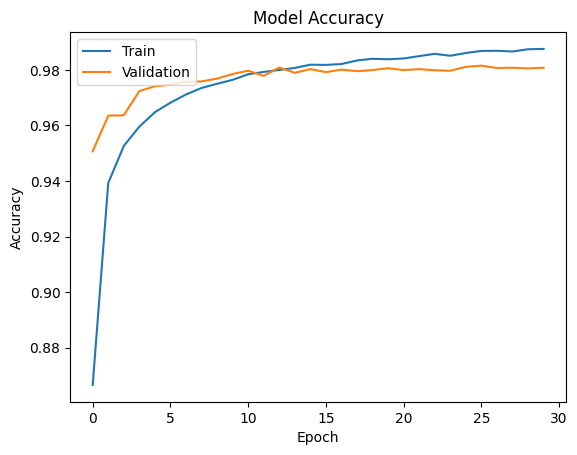

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

We can evaluate the Multilayer Neural Network

In [ ]:
# Evaluate model accuracy on test set
y_pred_cnn = np.argmax(modelnn.predict(x_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

313/313 [==============================] - 1s 2ms/step


In [ ]:
accuracy = accuracy_score(y_pred_cnn, y_test_cnn)
print('Test accuracy:', accuracy)

Test accuracy: 0.981


## 4. Convolutional Neural Networks

Now let's train a Convolutional Neural Network using the ``CIFAR 100`` dataset. As we did with the Multilayer Neural Network, we load and normalize data, and convert labels into categories. However, this time we don't reshape the ``Xs`` as we will fit a Convolutional Neural Network and we need to preserve the two-dimensional arrangement of pixels.  Additionally, the CIFAR-100 images have three color channels. By not reshaping the data, you ensure that the model can separately learn features from each of the color channels, which can be crucial for recognizing patterns that are dependent on color.

In [ ]:
# Load CIFAR-100 dataset
(x_train, y_train), (x_test, y_test) = cifar100.load_data()
print(x_train.shape)
print(x_test.shape)

# Normalize data
x_train = x_train / 255.0
x_test = x_test / 255.0

# Convert labels to categorical
y_train = to_categorical(y_train, num_classes=100)
y_test = to_categorical(y_test, num_classes=100)

169001437/169001437 [==============================] - 2s 0us/step
(50000, 32, 32, 3)
(10000, 32, 32, 3)


Let's display some random 100 pictures from the ``CIFAR 100`` dataset

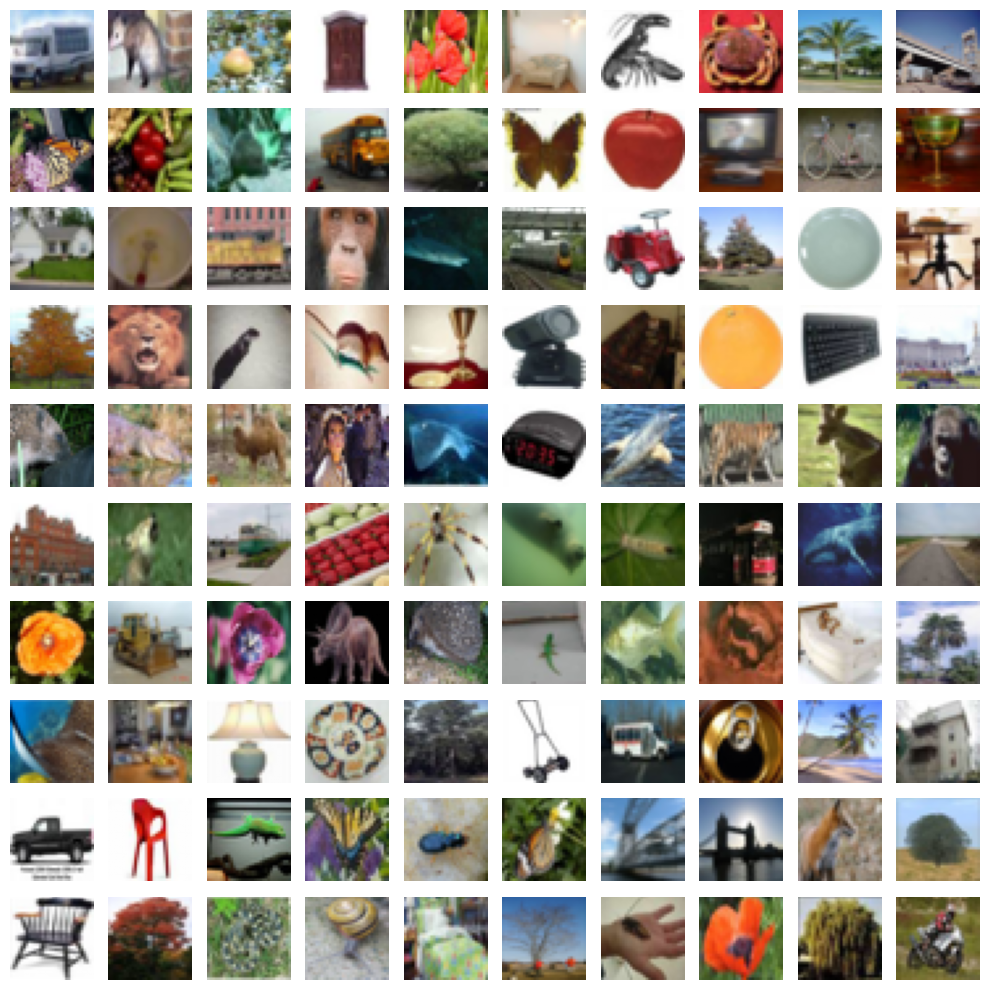

In [ ]:
fig, axes = plt.subplots(10, 10, figsize=(10, 10))
index = np.random.choice(range(50000), size=100, replace=False)
for i, ax in enumerate(axes.flatten()):
    ax.imshow(x_train[index[i]])
    ax.axis('off')
plt.tight_layout()
plt.show()

Now let's implement the Convolutional Neural Network:

**Model Architecture:**
- The model consists of a sequential stack of layers.
- It begins with multiple Conv2D layers, each followed by a MaxPooling2D layer, progressively extracting features and reducing spatial dimensions.
- The number of filters in the convolutional layers increases from 32 to 256, enabling the network to capture a wide range of features.
- A Flatten layer is used to convert the 2D feature maps into a 1D feature vector.
- A Dropout layer is incorporated to mitigate overfitting by randomly setting a fraction of the input units to zero during training.
- The network concludes with two Dense layers, the last of which uses softmax activation to output probabilities for the 100 classes.

**Compilation:**

- The model is compiled with categorical_crossentropy as the loss function, suitable for multi-class classification tasks, and RMSprop as the optimizer.
- The accuracy metric is included for performance evaluation.

**Training:**

- The model is trained using the ``fit`` method with specified epochs, batch size, and a portion of the training data reserved for validation.

In [ ]:
# Build the model
model = keras.Sequential([
        keras.layers.Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', input_shape=(32, 32, 3)),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=128, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Conv2D(filters=256, kernel_size=(3, 3), padding='same', activation='relu'),
        keras.layers.MaxPooling2D(pool_size=(2, 2)),
        keras.layers.Flatten(),
        keras.layers.Dropout(rate=0.5),
        keras.layers.Dense(units=512, activation='relu'),
        keras.layers.Dense(units=100, activation='softmax')
])

# Compile and train the model
model.compile(loss='categorical_crossentropy',
              optimizer=keras.optimizers.RMSprop(),
              metrics=['accuracy'])

history = model.fit(x_train, y_train, epochs=30, batch_size=128, validation_split=0.2)

Epoch 1/30
313/313 [==============================] - 137s 434ms/step - loss: 4.2407 - accuracy: 0.0473 - val_loss: 3.9367 - val_accuracy: 0.0821
Epoch 2/30
313/313 [==============================] - 136s 433ms/step - loss: 3.7113 - accuracy: 0.1272 - val_loss: 3.5779 - val_accuracy: 0.1533
Epoch 3/30
313/313 [==============================] - 134s 428ms/step - loss: 3.3465 - accuracy: 0.1919 - val_loss: 3.2448 - val_accuracy: 0.2140
Epoch 4/30
313/313 [==============================] - 129s 412ms/step - loss: 3.0798 - accuracy: 0.2378 - val_loss: 2.9333 - val_accuracy: 0.2694
Epoch 5/30
313/313 [==============================] - 129s 411ms/step - loss: 2.8638 - accuracy: 0.2828 - val_loss: 2.8457 - val_accuracy: 0.2950
Epoch 6/30
313/313 [==============================] - 132s 421ms/step - loss: 2.6784 - accuracy: 0.3189 - val_loss: 2.6506 - val_accuracy: 0.3278
Epoch 7/30
313/313 [==============================] - 132s 423ms/step - loss: 2.5113 - accuracy: 0.3535 - val_loss: 2.5453 -

Let's estimate the Accuracy of this model

In [ ]:
y_pred_cnn = np.argmax(model.predict(x_test), axis=1)
y_test_cnn = np.argmax(y_test, axis=1)

313/313 [==============================] - 9s 28ms/step


In [ ]:
accuracy = accuracy_score(y_pred_cnn, y_test_cnn)
print('Test accuracy:', accuracy)

Test accuracy: 0.4406


We can select random pictures from the test dataset and predict using the trained model

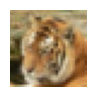

1/1 [==============================] - 0s 34ms/step
Predicted category is: tiger


In [ ]:
# Define class names
url = 'https://raw.githubusercontent.com/MartinThoma/algorithms/master/ML/confusion-matrix/labels/cifar-100-labels.json'
response = requests.get(url)
class_names = json.loads(response.content)

# Select a random image from test set
index = np.random.choice(x_test.shape[0], size=1, replace=False)
image_to_predict = x_test[index]

# Show the selected image
plt.figure(figsize=(1, 1))
plt.imshow(image_to_predict[0])
plt.axis('off')
plt.show()

# Predict category for selected image
predicted_category = model.predict(image_to_predict)

# Decodify category
predicted_category_index = np.argmax(predicted_category, axis=1)
predicted_category_name = class_names[predicted_category_index[0]]

print(f'Predicted category is: {predicted_category_name}')

# 6. LSTM Neural Network

**Dataset:** The IMDB dataset contains 50,000 movie reviews from the Internet Movie Database (IMDB) website. These reviews are labeled by sentiment (positive/negative). Each review has been preprocessed, and every word has been encoded as an integer, where each integer represents a unique word in the dictionary.

**Spliting stage:** The dataset is divided into two equal parts: 25,000 reviews for training and 25,000 reviews for testing. Each set contains 50% positive and 50% negative reviews.

In [ ]:
# Set parameters
max_features = 10000
maxlen = 500

# Load IMBD data
(x_train, y_train), (x_test, y_test) = imdb.load_data(num_words=max_features)

# Fill sequences for them to have the same lenght
x_train = sequence.pad_sequences(x_train, maxlen=maxlen)
x_test = sequence.pad_sequences(x_test, maxlen=maxlen)

17464789/17464789 [==============================] - 0s 0us/step


- **Load Word Index:** Retrieves the word index mapping from imdb.get_word_index(), which provides a dictionary where keys are words and values are the corresponding integer indices.

- **Reverse Word Index:** Inverts the word index to create a reverse_word_index, mapping integer indices back to their respective words. This is essential for transforming the encoded reviews back into readable text.

- **Define Decode Function:** decode_review is a function that converts a list of integers (representing a movie review) back into human-readable text. It handles special tokens like padding (<PAD>), sequence start (<START>), and unknown words (<UNK>) by replacing their numerical representations with these descriptive strings.
Display Random Reviews:

- **Showing reviews:** The script selects three random reviews from the training set and displays them. Each review is decoded into text using decode_review, and its sentiment (positive or negative) is displayed based on the corresponding label in y_train.

In [ ]:
# Load word index
word_index = imdb.get_word_index()

# Reverse word index
reverse_word_index = dict([(value, key) for (key, value) in word_index.items()])

# Decode function
def decode_review(text):
    # Define special tokens
    special_tokens = {0: '<PAD>', 1: '<START>', 2: '<UNK>'}
    # Decode the review, replace special tokens with their symbolic names
    return ' '.join([special_tokens.get(i, reverse_word_index.get(i - 3, '?')) for i in text])


# Show random reviews
for _ in range(3):
    index = np.random.randint(0, len(x_train))
    print(f'Reseña #{index}:')
    print(decode_review(x_train[index]))
    print('Sentimiento:', 'Positivo' if y_train[index] == 1 else 'Negativo')
    print('\n')

1641221/1641221 [==============================] - 0s 0us/step
Reseña #24375:
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <START> while the overall idea of escape from atlantis was intriguing i found the film to be far less than what i had hoped for upon reading the plot <UNK> perhaps i am too much of a child in the technological age the movie was made as it is now 2002 an official five years ago after viewing fantasy epics such as lord of the rings and science fiction <UNK> like star wars as a whole it could not compare to other movies of similar line such as <UNK> or <UNK> the odyssey 

Now let's train the LSTM model to binary classify text:

**Set Parameters:**

- ``max_features:`` Defines the number of unique words to consider in the dataset, allowing the model to focus on the most frequent words.
maxlen: Specifies the maximum length of the text sequences, ensuring uniform input size.
- ``batch_size:`` Determines the number of samples processed before the model is updated.

**Model Construction:**

- The model is built using the Sequential API.
- An Embedding layer transforms integer representations of words into dense vectors of fixed size, capturing semantic information.
- An LSTM layer processes the sequence data, capable of learning long-term dependencies. Dropout is applied to prevent overfitting.
- A Dense layer with a sigmoid activation function computes the probability of the text being positive or negative.

**Model Compilation:**

- The model is compiled with binary_crossentropy as the loss function, suitable for binary classification tasks.
- The adam optimizer is used for efficient stochastic gradient descent.
Accuracy is tracked as a metric to evaluate model performance.


**Model Training:**

- The model is trained on the preprocessed ``x_train`` and ``y_train`` data, iterating through the data in batches.
- Validation is performed on a separate test set (``x_test``, ``y_test``) to monitor model performance on unseen data.
- The training process runs for a predefined number of epochs.

In [ ]:
# Model architecture
lstm_model = Sequential()
lstm_model.add(Embedding(max_features, 128, input_length=maxlen))
lstm_model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
lstm_model.add(Dense(1, activation='sigmoid'))

# Compile
lstm_model.compile(loss='binary_crossentropy',
                   optimizer='adam',
                   metrics=['accuracy'])

# Compile and train the model
history = lstm_model.fit(x_train, y_train,
                         batch_size=32,
                         epochs=10,
                         validation_data=(x_test, y_test))

Epoch 1/10
782/782 [==============================] - 760s 967ms/step - loss: 0.5800 - accuracy: 0.7121 - val_loss: 0.4852 - val_accuracy: 0.7662
Epoch 2/10
782/782 [==============================] - 833s 1s/step - loss: 0.3562 - accuracy: 0.8553 - val_loss: 0.3360 - val_accuracy: 0.8652
Epoch 3/10
782/782 [==============================] - 841s 1s/step - loss: 0.2449 - accuracy: 0.9049 - val_loss: 0.3031 - val_accuracy: 0.8811
Epoch 4/10
782/782 [==============================] - 814s 1s/step - loss: 0.1708 - accuracy: 0.9390 - val_loss: 0.3135 - val_accuracy: 0.8796
Epoch 5/10
782/782 [==============================] - 837s 1s/step - loss: 0.1424 - accuracy: 0.9489 - val_loss: 0.3604 - val_accuracy: 0.8653
Epoch 6/10
782/782 [==============================] - 758s 969ms/step - loss: 0.1274 - accuracy: 0.9481 - val_loss: 0.3780 - val_accuracy: 0.8711
Epoch 7/10
782/782 [==============================] - 816s 1s/step - loss: 0.0945 - accuracy: 0.9652 - val_loss: 0.4579 - val_accuracy: 

Let's estimate the Accuracy of our LSTM model

In [ ]:
predicted_probs = lstm_model.predict(x_test)
y_pred_lstm = (predicted_probs > 0.5).astype("int32")

accuracy = accuracy_score(y_test, y_pred_lstm)
print('Test accuracy:', accuracy)

782/782 [==============================] - 91s 117ms/step
Test accuracy: 0.8158


Let's make a prediction over a random review. We follow these steps:

**Select a Random Review:** A single review is randomly chosen from the test dataset (x_test). The np.random.choice function ensures a random selection.

**Show the Selected Review:** The decode_review function is called to convert the sequence of integers back into human-readable text. The review is then printed, allowing you to read and understand its content.

**Predict Sentiment:** The LSTM model (lstm_model) predicts the sentiment of the selected review. The model outputs a sentiment score, representing the likelihood of the review being positive.


**Decode and Display Prediction:** The sentiment score is decoded into a class label ('Positive' or 'Negative'), based on a threshold of 0.5. The predicted class and the sentiment score are printed, providing insight into the model's interpretation of the review.

In [ ]:
# Select a random review
index = np.random.choice(x_test.shape[0], size=1, replace=False)
review_to_predict = x_test[index]

# Show the selected review
print("Review:")
print(decode_review(review_to_predict[0]))

# Predict over the selected review
predicted_sentiment = lstm_model.predict(review_to_predict)

# Decodify review
predicted_sentiment_score = predicted_sentiment[0][0]
predicted_class = 'Positive' if predicted_sentiment_score > 0.5 else 'Negative'

print(f'\nPredicted sentiment: {predicted_class} (Score: {predicted_sentiment_score:.4f})')

Review:
<PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <PAD> <P